In [1]:
from useful_scit.imps import *
# plt.style.use('Solarize_Light2')
plt.style.use('seaborn')
mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams['figure.figsize']=[4.0, 3.0]
# %config InlineBackend.figure_format = 'retina'

In [2]:
sys.path.insert(0,'../util/')
import funs
import fix_co
importlib.reload(funs);
importlib.reload(fix_co);

In [3]:
# df_hm = fix_co.get_maap_horiba_data()
# df_hm1 = fix_co.process_df_hm(df_hm)
# df_hm1.to_hdf('../data/maap_horiva_pd_data.h5','w')

In [4]:
df_hm1 = pd.read_hdf('../data/maap_horiva_pd_data.h5')

In [5]:
xs_co = funs.open_sat_co('../data/co_sat/')

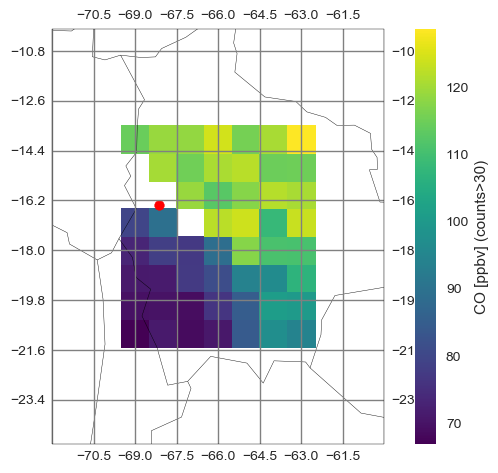

In [6]:
ax=fix_co.plot_co_sat(xs_co)

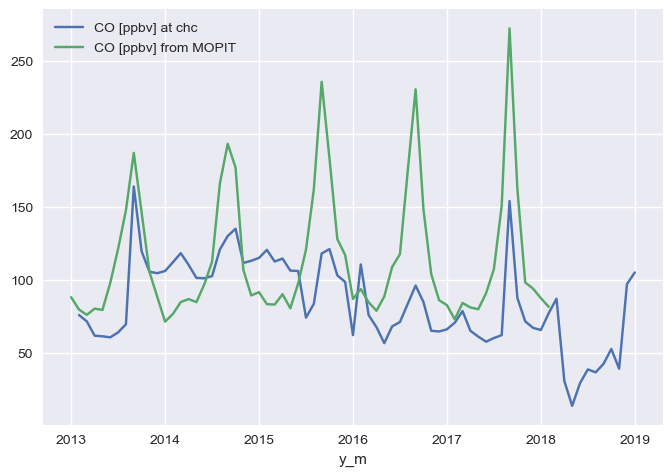

In [7]:
fix_co.plot_mopit_vs_hor(xs_co,df_hm1)

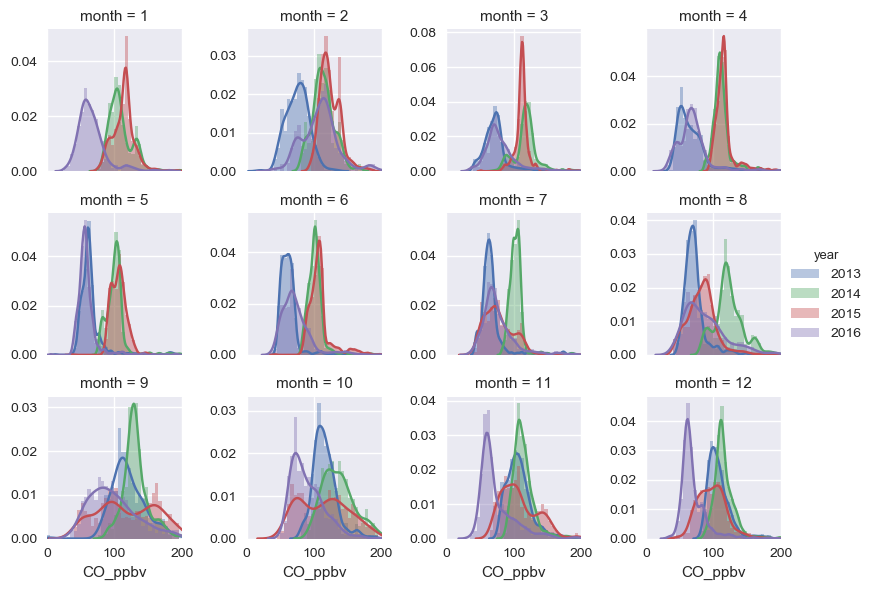

In [8]:
import warnings; warnings.simplefilter('ignore')
fix_co.plot_dists([2012,2013,2014,2015,2016],df_hm1)

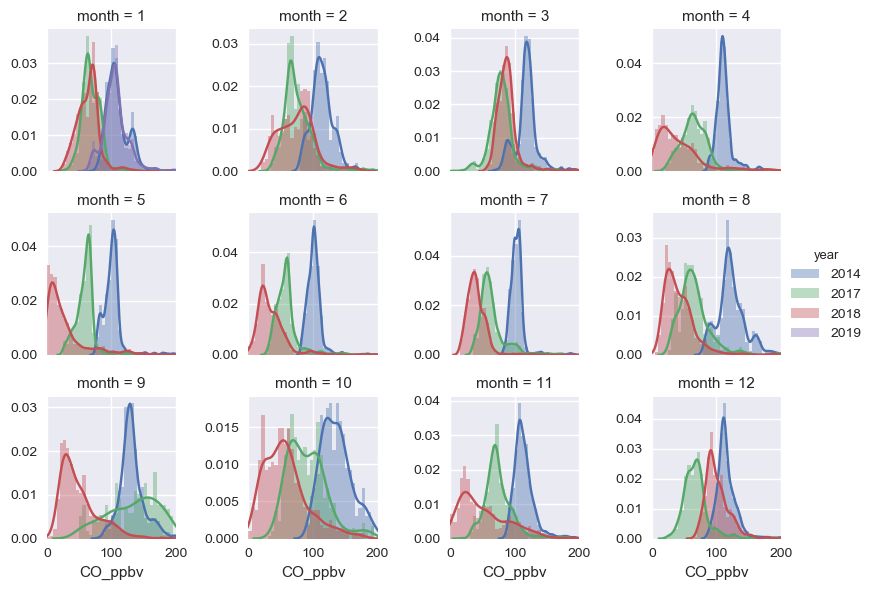

In [9]:
import warnings; warnings.simplefilter('ignore')
fix_co.plot_dists([2014,2017,2018,2019],df_hm1)

In [10]:
#info given by fernando: calibration horiba
periods = {
    'p1':{'t1':'2013-02-01 00','t2':'2013-09-03 23'},
    'p2':{'t1':'2014-09-04 00','t2':'2015-07-07 23'}, #good one
    'p3':{'t1':'2015-07-08 00','t2':'2018-03-30 23'},
    'p4':{'t1':'2018-03-31 00','t2':'2018-11-26 23'},
}

In [11]:
def select(p_dict):
    return slice(p_dict['t1'],p_dict['t2'])

def find_corr(df_hm1,periods,label_good,label_bad,month=4):
    from scipy.ndimage import gaussian_filter, gaussian_filter1d
    good = label_good


    dfg=df_hm1[select(periods[good])][df_hm1.month==4]
    dfb=df_hm1[select(periods[label_bad])][df_hm1.month==4]


    bins = np.arange(-500,500,1)

    vag = np.histogram(dfg.CO_ppbv.dropna().values,bins,normed=True)[0]
    vab = np.histogram(dfb.CO_ppbv.dropna().values,bins,normed=True)[0]

    hig = np.histogram(dfg.CO_ppbv.dropna().values,bins,normed=True)[0]
    vab = dfb.CO_ppbv.dropna().values
    def minimize_me(X,vab,hig,bins):
        hib = np.histogram(vab*X[0]+X[1],bins,normed=True)[0]
        res = np.sqrt(((gaussian_filter1d(hib,2)-gaussian_filter1d(hig,2))**2).sum())
        return res

    xl=101
    yl=102
    X = np.linspace(.2,2,xl)
    Y = np.linspace(1,200,yl)
    Z = np.zeros((xl,yl))

    for x in range(xl):
        for y in range(yl):
            Z[x,y]=minimize_me([X[x],Y[y]],vab,hig,bins)

    xa=xr.DataArray(Z,coords=[X,Y],dims=['X','Y'])

    res = xa.where(xa==xa.min(),drop=True).squeeze()
    res = {'ar':xa,'x':float(res.X),'y':float(res.Y)}
    return res 





In [12]:
df_hm2=df_hm1.copy()
res = find_corr(df_hm1,periods,'p2','p1',4)
df_hm2.loc[select(periods['p1']),'CO_ppbv']=df_hm2.loc[select(periods['p1']),'CO_ppbv']*res['x']+res['y']
res = find_corr(df_hm1,periods,'p2','p3',4)
df_hm2.loc[select(periods['p3']),'CO_ppbv']=df_hm2.loc[select(periods['p3']),'CO_ppbv']*res['x']+res['y']
res = find_corr(df_hm1,periods,'p2','p4',4)
df_hm2.loc[select(periods['p4']),'CO_ppbv']=df_hm2.loc[select(periods['p4']),'CO_ppbv']*res['x']+res['y']

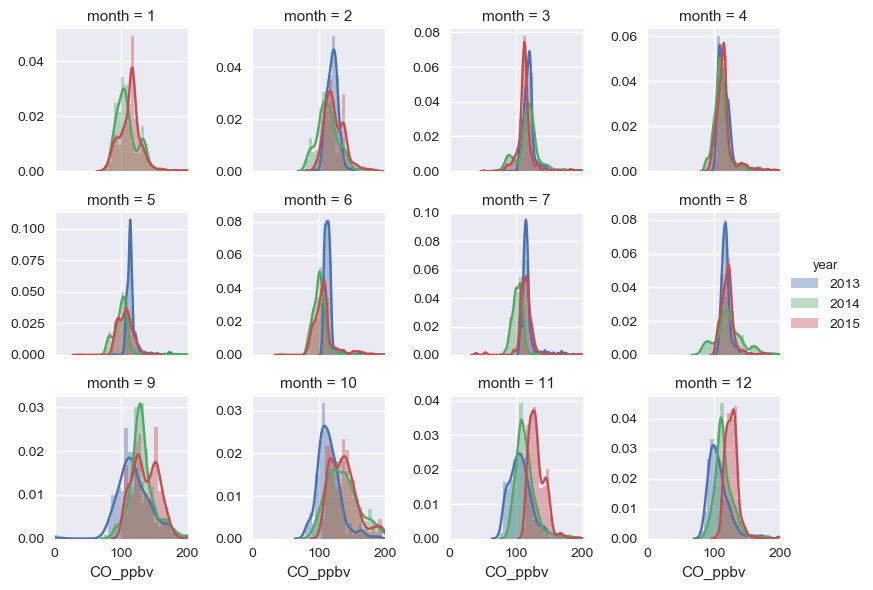

In [13]:
fix_co.plot_dists([2012,2013,2014,2015],df_hm2)

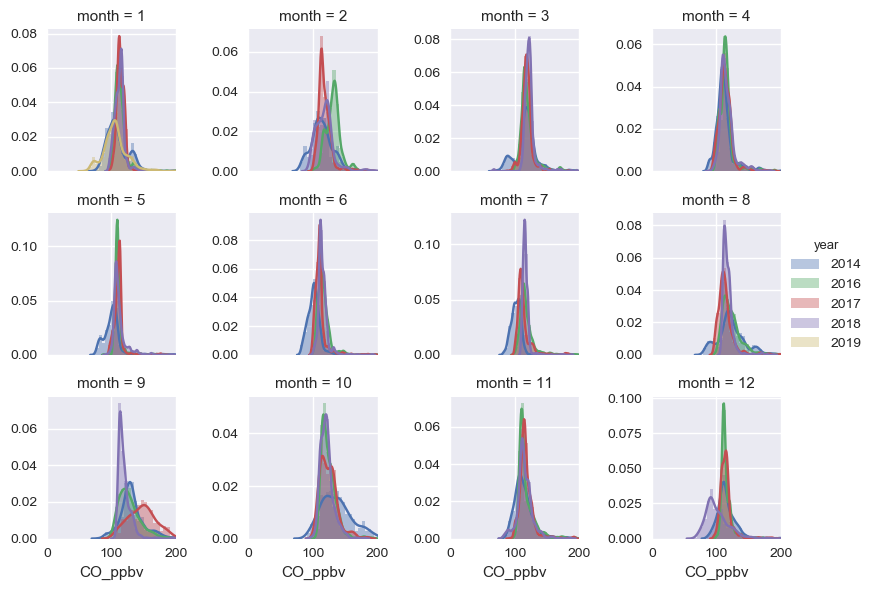

In [14]:
fix_co.plot_dists([2014,2016,2017,2018,2019],df_hm2)

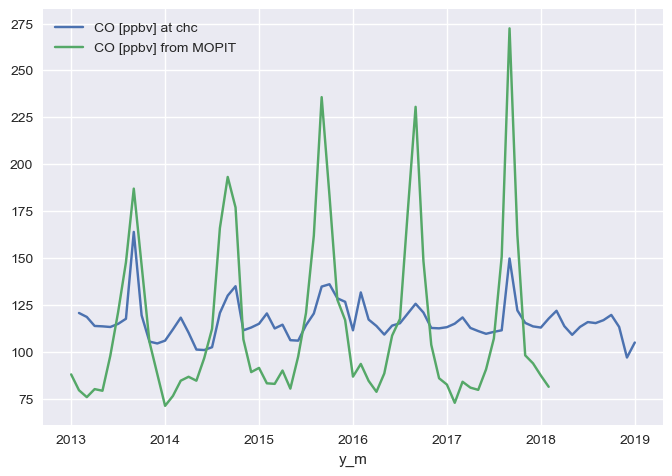

In [15]:
fix_co.plot_mopit_vs_hor(xs_co,df_hm2)

(90, 160)

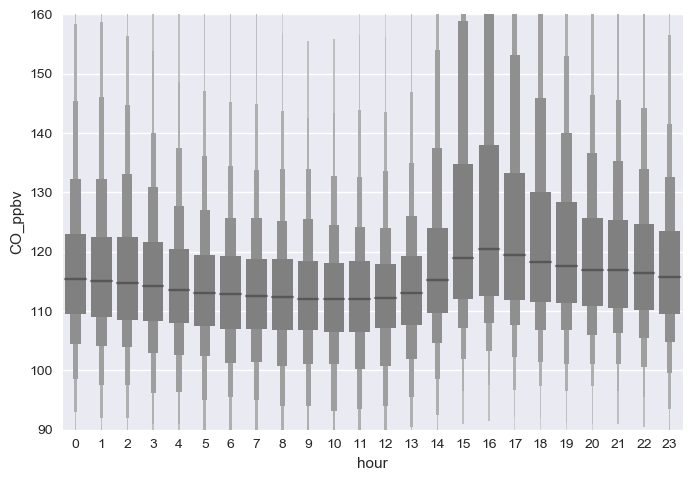

In [16]:
ax = sns.boxenplot(data=df_hm2, x = 'hour', y='CO_ppbv',color='grey')
ax.set_ylim(90,160)

In [17]:
# df_hm2.to_csv('../data/horiba_chc_corrected_diego.csv')

(0, 5)

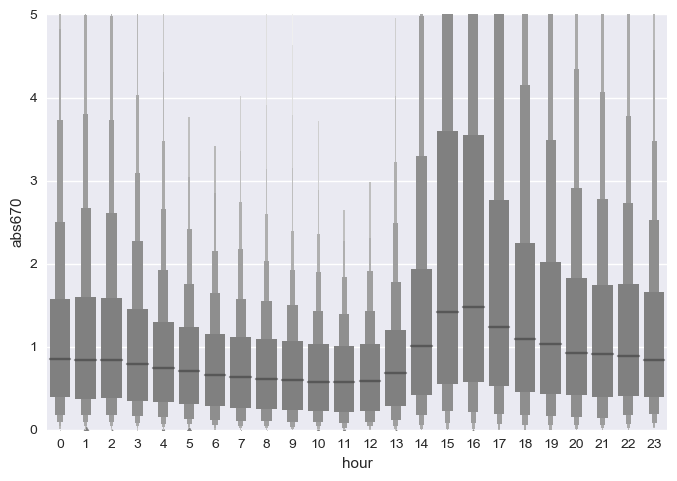

In [18]:
ax = sns.boxenplot(data=df_hm2, x = 'hour', y='abs670',color='grey')
ax.set_ylim(0,5)

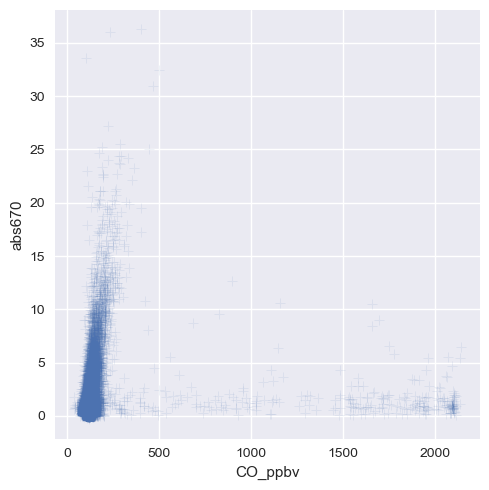

In [19]:
co = 'CO_ppbv'
ab = 'abs670'
sns.relplot(x=co,y=ab,data=df_hm2,alpha=.09,marker='+')

In [20]:
bo=df_hm2[co]>500
df_hm2[bo].groupby('y_m').count()[co]

y_m
2013-09-01    153
2013-10-01    144
Name: CO_ppbv, dtype: int64

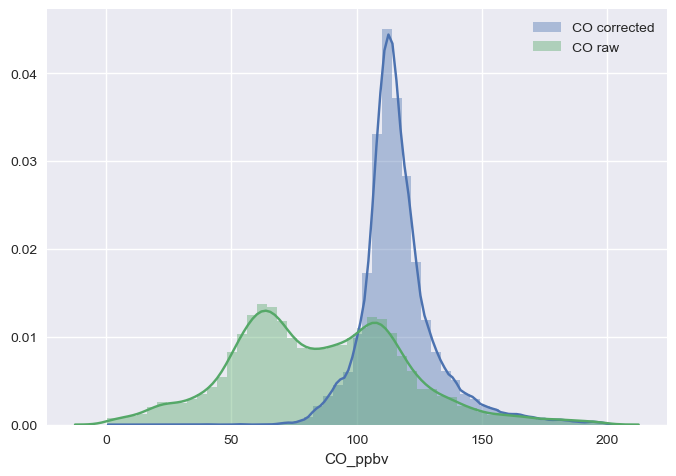

In [21]:
def set_range(df): 
    return df[df[co]<200][df[co]>0][co].dropna()
ax=sns.distplot(set_range(df_hm2),label='CO corrected')
ax=sns.distplot(set_range(df_hm1),ax=ax, label='CO raw')
ax.legend()

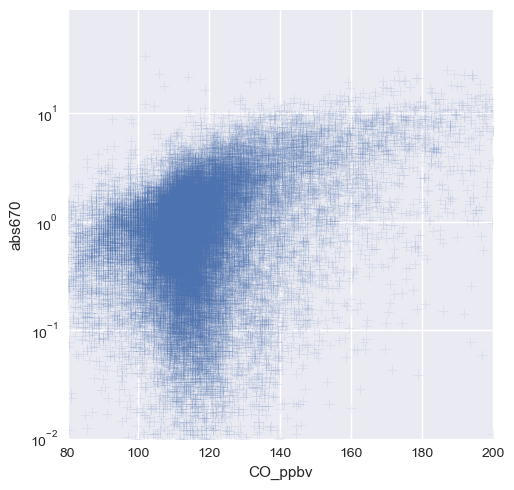

In [22]:
fp=sns.relplot(x=co,y=ab,data=df_hm2,alpha=.09,marker='+')
fp.ax.set_xlim(80,200);
# fp.ax.loglog()
fp.ax.set_ylim(.01,90)
fp.ax.set_yscale('log')

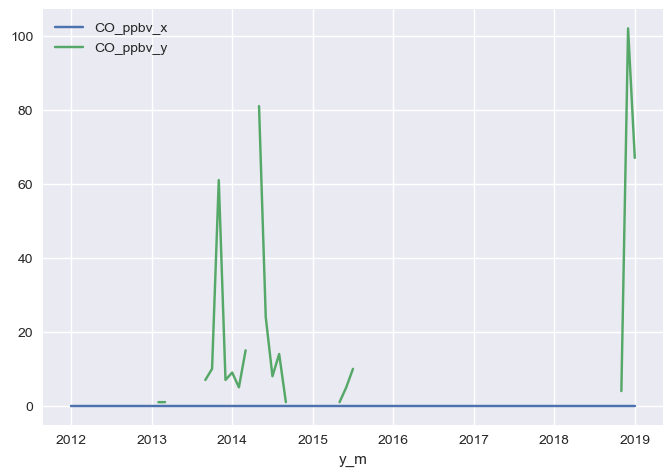

In [23]:
bo = df_hm2[co]<85
res=df_hm2[bo].groupby('y_m').count()[[co]]
d0 = df_hm2.groupby('y_m').count()[[co]].copy()
d0[co] = 0
pd.merge(d0,res,how='left',left_index=True,right_index=True).plot()

In [24]:
col = 'log$_{10}$(CO_ppbv-100)'
df_hm3=df_hm2.copy()
df_hm3[col]=df_hm3[co]-95
df_hm3.loc[df_hm3[col]<=0,col]=1
df_hm3[col]=np.log10(df_hm3[col])

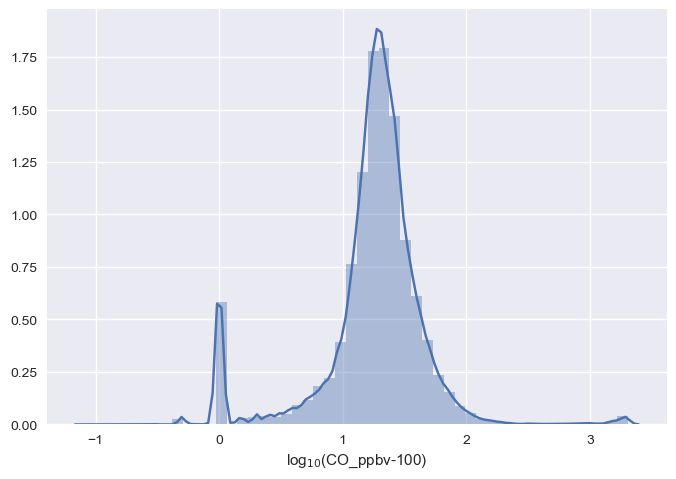

In [25]:
sns.distplot(df_hm3[col].dropna())

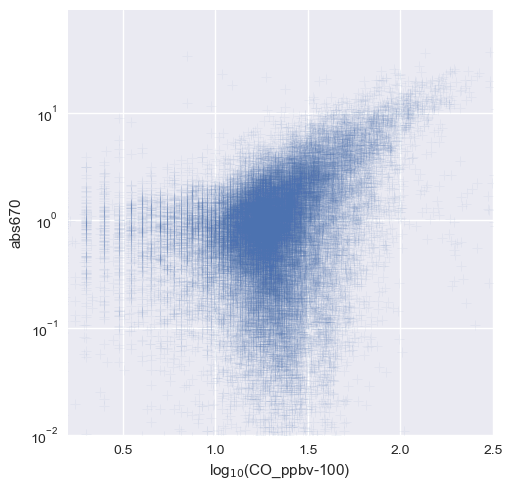

In [26]:
fp=sns.relplot(x=col,y=ab,data=df_hm3,alpha=.05,marker='+')
fp.ax.set_xlim(.2,2.5);
# fp.ax.loglog()
fp.ax.set_ylim(.01,90)
fp.ax.set_yscale('log')

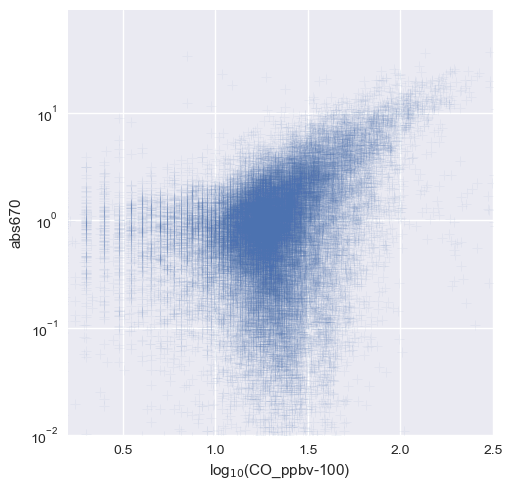

In [27]:
fp=sns.relplot(x=col,y=ab,data=df_hm3,alpha=.05,marker='+')
fp.ax.set_xlim(.2,2.5);
# fp.ax.loglog()
fp.ax.set_ylim(.01,90)
fp.ax.set_yscale('log')

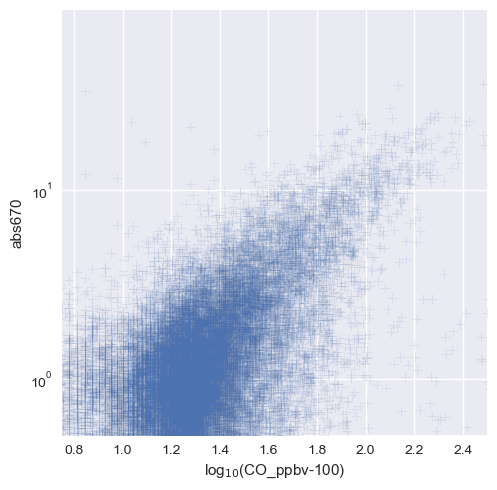

In [28]:
fp=sns.relplot(x=col,y=ab,data=df_hm3,alpha=.1,marker='+')
fp.ax.set_xlim(.75,2.5);
# fp.ax.loglog()
fp.ax.set_ylim(.5,90)
fp.ax.set_yscale('log')

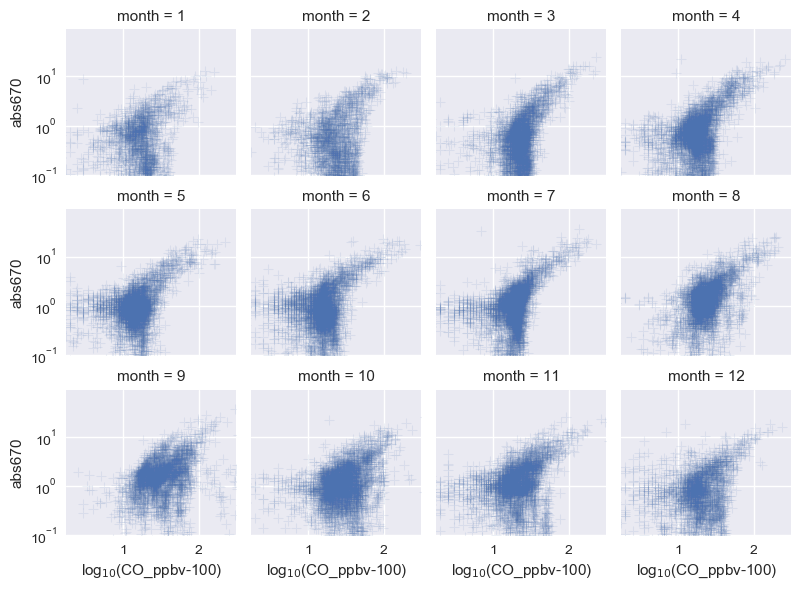

In [33]:
fp=sns.relplot(height=2,x=col,y=ab,data=df_hm3,alpha=.1,marker='+',col='month',
              col_wrap=4)
ax=fp.axes[0]
ax.set_xlim(.25,2.5);
# fp.ax.loglog()
ax.set_ylim(.1,90)
ax.set_yscale('log')

In [30]:
fp.axes[0]

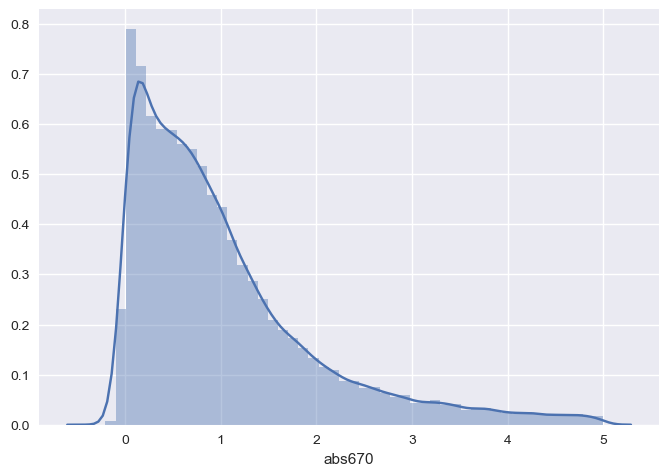

In [31]:
sns.distplot(df_hm3[df_hm3[ab]<5][ab].dropna())